In [29]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM, BatchNormalization, ReLU
from keras.layers import Dropout, Dense, TimeDistributed, Reshape, Bidirectional
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
!pip install --upgrade scikit-learn
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

In [30]:
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
BATCH_SIZE = 32
N_CLASSES = 7

In [31]:
# Make a dataset containing the training spectrograms
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             directory='/kaggle/input/tess-full/TESS/Mel_Spectrograms/Train',
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH))

# Make a dataset containing the validation spectrogram
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             directory='/kaggle/input/tess-full/TESS/Mel_Spectrograms/Test',
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH))

Found 8960 files belonging to 7 classes.
Found 560 files belonging to 7 classes.


In [32]:
def get_conv_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation = 'relu', strides = (1, 1), padding = 'same', input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
  model.add(BatchNormalization())
  model.add(MaxPool2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation = 'relu', strides = (1, 1), padding = 'same'))
  model.add(BatchNormalization())
  model.add(MaxPool2D((2, 2)))
  model.add(Conv2D(128, (3, 3), activation = 'relu', strides = (1, 1), padding = 'same'))
  model.add(BatchNormalization())
  model.add(MaxPool2D((2, 2)))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(64, activation = 'relu'))
  model.add(Dense(32, activation = 'relu'))
  model.add(Dense(7, activation = 'softmax'))
  model.summary()
  model.compile(loss = 'sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001), metrics = ['acc'])
  return model

In [33]:
model_name = 'CNN'
model = get_conv_model()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │     2,097,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,193,671 (8.37 MB)

 Trainable params: 2,193,223 (8.37 MB)

 Non-trainable params: 448 (1.75 KB)

In [34]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [35]:
history = model.fit(train_dataset, epochs = 40, batch_size = 32, validation_data=valid_dataset, callbacks = [early_stopping], verbose = 1)
# history = model.fit(train_dataset, epochs = 50, batch_size = 32, validation_data=valid_dataset, verbose = 1)

Epoch 1/40
280/280 ━━━━━━━━━━━━━━━━━━━━ 24s 66ms/step - acc: 0.7326 - loss: 1.1627 - val_acc: 1.0000 - val_loss: 0.0148
Epoch 2/40
280/280 ━━━━━━━━━━━━━━━━━━━━ 19s 66ms/step - acc: 0.9992 - loss: 0.0194 - val_acc: 1.0000 - val_loss: 0.0056
Epoch 3/40
280/280 ━━━━━━━━━━━━━━━━━━━━ 19s 65ms/step - acc: 1.0000 - loss: 0.0043 - val_acc: 1.0000 - val_loss: 0.0022
Epoch 5/40
280/280 ━━━━━━━━━━━━━━━━━━━━ 19s 65ms/step - acc: 1.0000 - loss: 0.0024 - val_acc: 1.0000 - val_loss: 0.0013
Epoch 6/40
280/280 ━━━━━━━━━━━━━━━━━━━━ 19s 65ms/step - acc: 1.0000 - loss: 0.0014 - val_acc: 1.0000 - val_loss: 9.0307e-04
Epoch 7/40
280/280 ━━━━━━━━━━━━━━━━━━━━ 19s 66ms/step - acc: 1.0000 - loss: 0.0011 - val_acc: 1.0000 - val_loss: 6.2523e-04
Epoch 8/40
280/280 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - acc: 1.0000 - loss: 6.3625e-04 - val_acc: 1.0000 - val_loss: 7.0328e-04
Epoch 9/40
280/280 ━━━━━━━━━━━━━━━━━━━━ 19s 66ms/step - acc: 1.0000 - loss: 5.4063e-04 - val_acc: 1.0000 - val_loss: 3.7385e-04
Epoch 10/40
280/

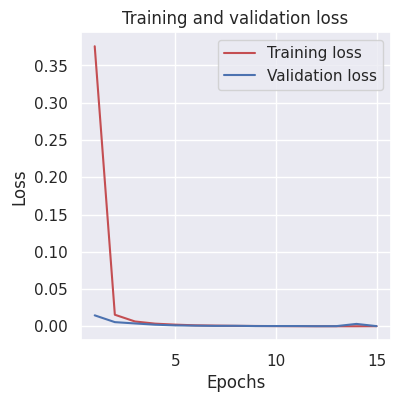

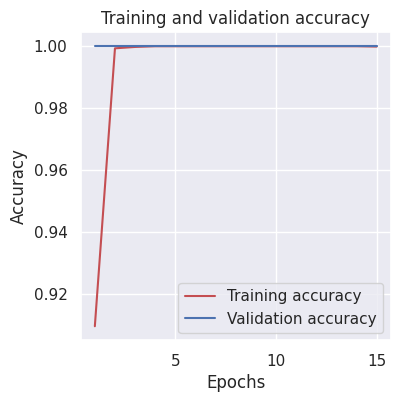

Final loss: 0.000068, final accuracy: 1.000000
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Classification Report:
              precision    recall  f1-score   support

       Anger       1.00      1.00      1.00        80
     Disgust       1.00      1.00      1.00        80
        Fear       1.00      1.00      1.00        80
       Happy       1.00      1.00      1.00        80
     Neutral       1.00      1.00      1.00        80
         Sad       1.00      1.00      1.00        80
    Surprise       1.00      1.00      1.00        80

    accuracy                           1.00       560
   macro avg       1.00      1.00      1.00       560
weighted avg       1.00      1.00      1.00       560



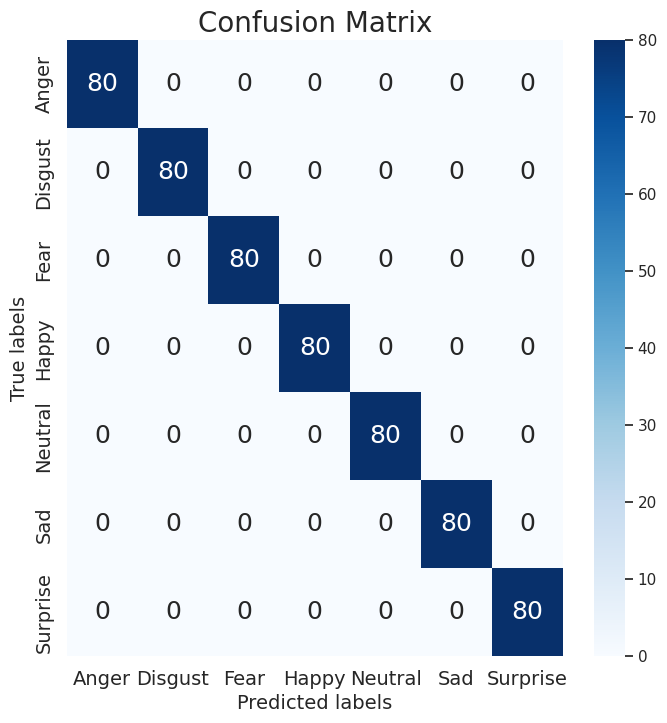

In [36]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)
    
plt.figure(figsize=(4,4))
plt.plot(epochs, loss_values, 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curves for training and validation.
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(4,4))
plt.plot(epochs, acc_values, 'r', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Compute the final loss and accuracy
final_loss, final_acc = model.evaluate(train_dataset, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming `test_dataset` contains your test data and labels, and `model` is your trained Keras model
test_images = []
test_labels = []
for images, labels in valid_dataset:
    test_images.append(images.numpy())
    test_labels.append(labels.numpy())
test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)

# Get model predictions on the test data
y_pred = np.argmax(model.predict(test_images), axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(test_labels, y_pred)
class_names = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

from sklearn.metrics import classification_report
# Generate the classification report
report = classification_report(test_labels, y_pred, target_names=class_names)

# Print the classification report
print('Classification Report:')
print(report)

# Define the class labels
class_names = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Plot the confusion matrix using Seaborn's heatmap function
sns.set()
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True,fmt='d', cmap='Blues', annot_kws={"fontsize": 18}, xticklabels=class_names, yticklabels=class_names)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14) 
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted labels', size=14)
plt.ylabel('True labels', size=14)
plt.show()